In [5]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelmax,argrelmin
from multiprocessing import Pool
import datetime as dt
import util
import pandas as pd
import seaborn as sns; sns.set()
import pprint
import functools
import math, random

In [195]:
profit_calendar=
{2: ['HCA'],
 4: ['ORLY'],
 5: ['DLPH', 'HOLX'],
 11: ['TSCO', 'TRIP'],
 12: ['SYF', 'NFLX'],
 13: ['CXO', 'VLO'],
 14: ['CMG'],
 15: ['WYN'],
 16: ['GPS', 'RRC'],
 17: ['NWSA', 'NWS', 'CFG', 'LYB'],
 18: ['KSS', 'PXD', 'FLS', 'V'],
 19: ['HBI', 'FBHS'],
 23: ['VFC'],
 24: ['PCLN', 'MRO'],
 26: ['IR', 'IT'],
 27: ['TMK'],
 28: ['DG', 'KORS'],
 29: ['DLPH', 'ABBV'],
 32: ['NAVI'],
 34: ['QRVO'],
 35: ['ALLE'],
 36: ['CMG'],
 37: ['PSX'],
 40: ['YUM', 'DFS'],
 43: ['FBHS'],
 44: ['ADS'],
 46: ['TRIP', 'CXO', 'CBG'],
 48: ['MNK'],
 49: ['ULTA', 'LYB'],
 56: ['HAL', 'ABBV'],
 59: ['DG'],
 69: ['SYF'],
 71: ['UHS'],
 74: ['FBHS', 'FB'],
 77: ['NAVI'],
 81: ['QRVO'],
 92: ['CXO'],
 95: ['TRIP', 'ULTA'],
 98: ['UAA'],
 101: ['PSX', 'INFO'],
 104: ['HCA', 'MNK'],
 118: ['FBHS'],
 119: ['KORS'],
 120: ['LKQ', 'SYF'],
 122: ['ALLE'],
 123: ['UAA'],
 124: ['ABBV', 'AAPL'],
 126: ['NAVI', 'AMGN'],
 128: ['INFO'],
 129: ['FB'],
 131: ['ALXN'],
 132: ['KMI'],
 135: ['CBOE'],
 141: ['MPC'],
 143: ['CFG'],
 149: ['HCA'],
 150: ['LYB'],
 151: ['PSX', 'FBHS'],
 152: ['KORS', 'DFS', 'UAL', 'NVDA'],
 155: ['DLPH'],
 160: ['ICE'],
 161: ['CBOE'],
 162: ['CME'],
 163: ['DISCK'],
 164: ['RJF'],
 168: ['ABBV'],
 173: ['V'],
 186: ['DLPH'],
 187: ['ICE', 'SYF', 'ALK'],
 188: ['QRVO'],
 189: ['SNI'],
 190: ['GM', 'PSX'],
 193: ['BK'],
 194: ['FBHS'],
 195: ['GOOG', 'MA', 'NUE'],
 196: ['FMC'],
 198: ['ABBV'],
 201: ['FLIR', 'HRS'],
 202: ['COTY'],
 205: ['NVDA', 'WDC', 'EQIX'],
 206: ['MTD', 'DE', 'TDG'],
 207: ['SHW'],
 208: ['HCA'],
 210: ['CNC', 'VMC'],
 214: ['MNK'],
 219: ['GM'],
 221: ['FBHS'],
 223: ['NUE', 'AWK'],
 224: ['DHI', 'PHM', 'WHR', 'LUK', 'HON', 'CTSH', 'EXR'],
 225: ['HP', 'CAH'],
 226: ['COG', 'HOLX', 'ZBH', 'CBG', 'PSA'],
 227: ['EL', 'VLO', 'HUM', 'ARE', 'DLR'],
 228: ['CRM'],
 230: ['COTY', 'CFG'],
 231: ['VRSK'],
 235: ['TRIP'],
 237: ['DLPH'],
 238: ['CF'],
 242: ['DG', 'ILMN'],
 243: ['MOS'],
 247: ['ROST'],
 248: ['KMI'],
 249: ['KORS']}
print len(profit_calendar)

flat_list = [item for sublist in profit_calendar.values() for item in sublist]
len(flat_list)

100


188

<IPython.core.display.Javascript object>


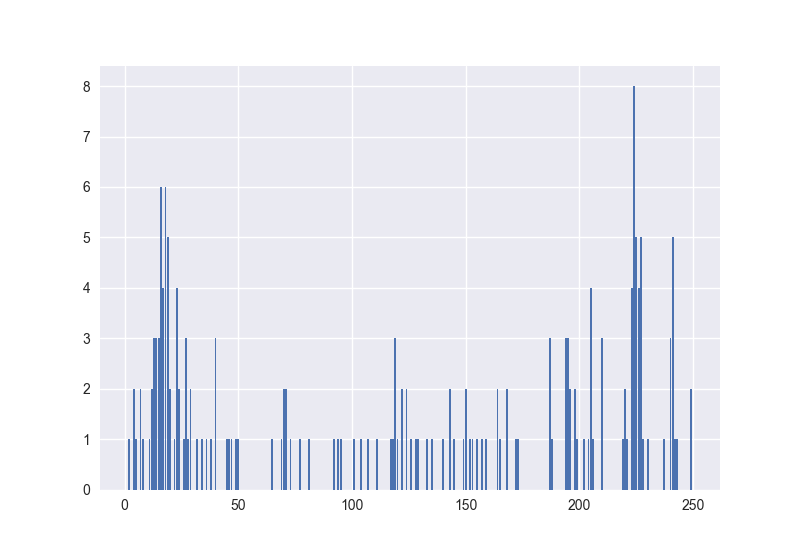

In [210]:

plt.figure(1)

plt.subplot()
plt.bar(profit_calendar.keys(),map(len,profit_calendar.values()))

plt.show()

In [29]:
sd = dt.date(2005,1,1)
ed = dt.date(2017,12,31)
sym='NVDA'
df = pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close'])
len(df[dt.date(2017,1,1):])

203

In [252]:
def generate_dataframes(profit_calendar):
    syms= [item for sublist in profit_calendar.values() for item in sublist]
    return {sym: pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close']) for sym in syms}
    
def backtest(profit_calendar, sy, ey, sv, max_age=63, max_profit=0.15, dataframes=None):
    if dataframes is None: dataframes=generate_dataframes(profit_calendar)
    
    commission = 5.00
    cash = sv
    portfolio = {
        # sym: (enter_date, purchase_price, shares)
    }
    for year in range(sy,ey):
        for day in range(0,252):
            print("Year: %d, Day: %d,  Cash:%0.2f,  Portfolio: %d items"%(year,day,cash,len(portfolio.keys())))
            # Sell Positions
            for sym,pos in portfolio.items():
                df = dataframes[sym]
                df = df[ dt.date(year,1,1):]
                price = float(df.iloc[day] )
                pos_age = 0
                if day < pos[0]: 
                    pos_age = (day+252) - pos[0]
                else:
                    pos_age = day - pos[0]
                if (pos_age > max_age) or ( (price / pos[1]) >= max_profit):
                    profit = (price - pos[1]) * pos[2]
                    portfolio.pop(sym,None) # Remove position from portfolio
                    cash += (price * pos[2]) - commission
                    print ("Sell %sx%d @ %0.2f %0.2f$  profit: %0.2f %0.2f%%, Age: %d"%(sym,pos[2],price, price*pos[2],profit, 100*(price/pos[1] -1),pos_age ))
                    continue

            
            # Buy Positions
            if day not in profit_calendar.keys(): continue
            for sym in profit_calendar[day]:
                if cash < sv/10.: 
                    continue
                if sym in portfolio.keys(): continue
                df = dataframes[sym]
                df = df[ dt.date(year,1,1):]
                price = float(df.iloc[day])
                shares = math.floor((cash/4.)/price)
                if shares > 500: shares = 500
                cash -= (price * shares) + commission
                portfolio[sym]=(day,price,shares)
                print ("Buy %sx%d @ %0.2f  -$%0.2f$"%(sym,shares,price, shares*price))
    print portfolio
    portfolio_pval=sum([pos[1] * pos[2] for pos in portfolio.values()])
    portfolio_val=sum([float(dataframes[sym][dt.date(year,1,1):].iloc[day] * pos[2])-5.00 for sym,pos in portfolio.items()])
    print "End Cash %0.2f,  Portfolio Value: %0.2f, Portfolio Purchase Value: %0.2f,   Total assets %0.2f"%(cash,portfolio_val, portfolio_pval, cash+portfolio_val )
    print "Total Gains $%0.2f, %0.2f%%"%( cash+portfolio_val - sv, ( (cash+portfolio_val )/sv -1) * 100)

In [203]:
 dataframes= generate_dataframes(profit_calendar)

In [55]:
len(dataframes)

128

In [257]:
 backtest(profit_calendar, 2013,2017, 50000, 70, 1.17,  dataframes)

Year: 2013, Day: 0,  Cash:50000.00,  Portfolio: 0 items
Year: 2013, Day: 1,  Cash:50000.00,  Portfolio: 0 items
Year: 2013, Day: 2,  Cash:50000.00,  Portfolio: 0 items
Buy HCAx391 @ 31.94  -$12488.54$
Year: 2013, Day: 3,  Cash:37506.46,  Portfolio: 1 items
Year: 2013, Day: 4,  Cash:37506.46,  Portfolio: 1 items
Buy AZOx26 @ 348.25  -$9054.50$
Buy HOLXx340 @ 20.89  -$7102.60$
Year: 2013, Day: 5,  Cash:21339.36,  Portfolio: 3 items
Buy ISRGx31 @ 168.91  -$5236.21$
Year: 2013, Day: 6,  Cash:16098.15,  Portfolio: 4 items
Year: 2013, Day: 7,  Cash:16098.15,  Portfolio: 4 items
Buy DLPHx105 @ 38.09  -$3999.45$
Buy ABBVx89 @ 33.85  -$3012.65$
Year: 2013, Day: 8,  Cash:9076.05,  Portfolio: 6 items
Buy ORLYx25 @ 88.55  -$2213.75$
Year: 2013, Day: 9,  Cash:6857.30,  Portfolio: 7 items
Year: 2013, Day: 10,  Cash:6857.30,  Portfolio: 7 items
Year: 2013, Day: 11,  Cash:6857.30,  Portfolio: 7 items
Buy CXOx19 @ 88.30  -$1677.70$
Year: 2013, Day: 12,  Cash:5174.60,  Portfolio: 8 items
Buy FLx38 @ 33.

In [248]:
holidays = [
    dt.date(2017,1,2),
    dt.date(2017,1,16),
    dt.date(2017,2,20),
    dt.date(2017,4,14),
    dt.date(2017,5,29),
    dt.date(2017,7,4),
    dt.date(2017,9,4),
    dt.date(2017,11,23),
    dt.date(2017,12,25),
    dt.date(2018,1,1),
    dt.date(2018,1,15),
    dt.date(2018,2,19),
    dt.date(2018,3,30),
    dt.date(2018,5,28),
    dt.date(2018,7,4),
    dt.date(2018,9,3),
    dt.date(2018,11,22),
    dt.date(2018,12,25)
    ]

In [249]:
trading_day=0
for day in (dt.date(2017,1,1) + dt.timedelta(n) for n in range(365)):
    if day.weekday() < 5 and day not in holidays:
        trading_day += 1
        if profit_calendar.has_key(trading_day):
            print "%d: %s: %s"%(trading_day,day.strftime("%a %Y-%m-%d"),profit_calendar[trading_day])
            print "\tExit:%s"%(day+timedelta(70))

2: Wed 2017-01-04: ['HCA']
4: Fri 2017-01-06: ['AZO', 'HOLX']
5: Mon 2017-01-09: ['ISRG']
7: Wed 2017-01-11: ['DLPH', 'ABBV']
8: Thu 2017-01-12: ['ORLY']
11: Wed 2017-01-18: ['CXO']
12: Thu 2017-01-19: ['FL', 'SYF']
13: Fri 2017-01-20: ['JBHT', 'PWR', 'NFLX']
14: Mon 2017-01-23: ['CMG', 'ALLE', 'VRSN']
15: Tue 2017-01-24: ['FAST', 'FLS', 'CBG']
16: Wed 2017-01-25: ['DISCK', 'GPS', 'TRIP', 'PXD', 'RRC', 'MLM']
17: Thu 2017-01-26: ['NWSA', 'PSX', 'CFG', 'LYB']
18: Fri 2017-01-27: ['ICE', 'UHS', 'IR', 'GLW', 'V', 'EMN']
19: Mon 2017-01-30: ['KORS', 'TSCO', 'FBHS', 'URI', 'CTXS']
20: Tue 2017-01-31: ['HAS', 'XYL']
22: Thu 2017-02-02: ['HBI']
23: Fri 2017-02-03: ['PCLN', 'VFC', 'WYN', 'PCAR']
24: Mon 2017-02-06: ['M', 'MRO']
26: Wed 2017-02-08: ['IT']
27: Thu 2017-02-09: ['XEC', 'TMK', 'DLR']
28: Fri 2017-02-10: ['DG']
29: Mon 2017-02-13: ['DLPH', 'ABBV']
32: Thu 2017-02-16: ['NAVI']
34: Tue 2017-02-21: ['QRVO']
36: Thu 2017-02-23: ['DISH']
38: Mon 2017-02-27: ['DPS']
40: Wed 2017-03-01: ['